<a href="https://colab.research.google.com/github/babalooski/BIOE486/blob/main/HW4_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# In this HW you are going to build a Fully Convolutional Autoencoder-like network for denoising image data (MR images)
# Please provide a high-level summary of architecture implementation
# Also ensure that you include accuracy and loss curves for each network, similar to previous HWs.
# Reference the most appropriate metrics when performing your analysis.
# Remember presentation is a component of your grading - ensure that your results are neat and concise.

# Some useful packages
# conda install -c anaconda scikit-image
# conda install -c anaconda scikit-learn

# Import statements and paths
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from random import sample
from skimage.util import random_noise
from sklearn.model_selection import train_test_split # split training and testing dataset
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio
from scipy.io import loadmat


from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Task 1 (10 pts): Import Data; note that the data were already normalized bewtten [0,1]
# Here we are going to write a data loading script
def MatLoader(data_dir):
    mat_files   = [f for f in os.listdir(data_dir) if f.endswith('.mat')]
    mat_data    = []
    for f in tqdm(mat_files, desc="Loading .mat files"):
      # ---
      # Put your codes here to load the image data from .mat files (Matlab data format)
      # ---
      mat = loadmat(os.path.join(data_dir, f))

      # Access the 'image' key
      if 'image' in mat:
          data = mat['image']  # Extract the image data
          # Check if the image is flattened and reshape it
          # if len(data.shape) == 1:  # Flattened array
          #     side_length = int(np.sqrt(data.shape[0]))  # Assuming square images
          #     data = data.reshape(side_length, side_length)
          # elif len(data.shape) == 2:  # Already in 2D format
          #     pass
          # print(data.shape)
          # data = np.squeeze(data)
          data = np.resize(data, (192, 192))

          mat_data.append(data)

    # if len(mat_data) == 0:
    #     raise ValueError("No valid .mat files found or no data loaded.")




    return np.double(np.stack(mat_data, axis=0))

data_dir = './drive/MyDrive/TrainingDataDenoising' # Put your own data directory here

totalData   = MatLoader(data_dir) # You don't need to use the same name as "totalData"
print(totalData.shape)  # check the data size (the first dimension should be the number of samples)

Loading .mat files: 100%|██████████| 2000/2000 [00:13<00:00, 150.57it/s]


(2000, 192, 192)


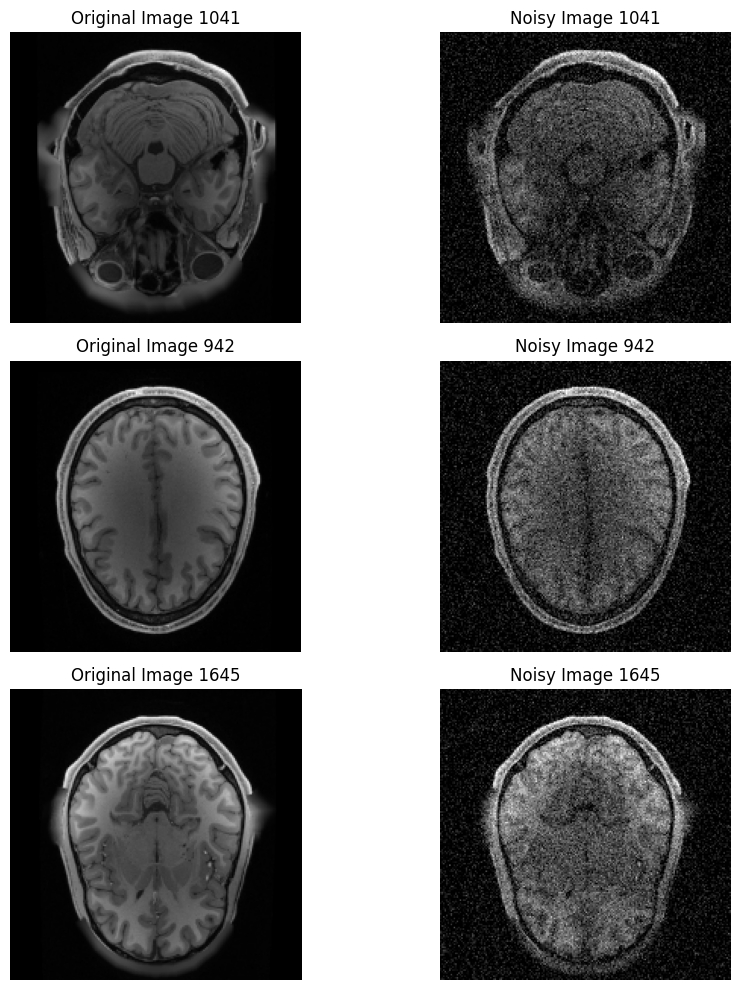

In [4]:
# Task 2a (10 pts): Add noise: Add white Gaussian noise with a variance 0.01 (noise standard deviation of 0.1)
variance    = 0.01
noisyData   = np.zeros(totalData.shape)

# ---
# Put your codes here
# ---
# std_dev = np.sqrt(variance)
# noisyData += totalData + np.random.normal(0, std_dev, totalData.shape)
for i in range(totalData.shape[0]):
    noisyData[i] = random_noise(totalData[i], mode='gaussian', var=variance)

# Visualization: random select 3 images and the simulated noisy counter part
item = sample(list(np.random.permutation(totalData.shape[0])), 3)

# ---
# Put your codes here
# ---
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, idx in enumerate(item):
    # Original image
    axes[i, 0].imshow(totalData[idx], cmap='gray')
    axes[i, 0].set_title(f"Original Image {idx}")
    axes[i, 0].axis('off')

    # Noisy image
    axes[i, 1].imshow(noisyData[idx], cmap='gray')
    axes[i, 1].set_title(f"Noisy Image {idx}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


# ---
# Put your codes here
# ---

In [5]:
# Task 2b (10 pts): Split into training and testing sets
# ---
# Put your codes here
# Hints: the "train_test_split" function from sklearn.model_selection is a good choice
# ---
totalData = np.expand_dims(totalData, axis=1)
noisyData = np.expand_dims(noisyData, axis=1)
X_train, X_test, y_train, y_test = train_test_split(noisyData, totalData, test_size=0.2, random_state=42)

# print(noisyData.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
batch_size = 32

# ---
# Your codes here to convert data into torch tensor format and create a data loader
# ---
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Assuming labels are integers (for classification)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# ---
# Your codes here to convert data into torch tensor format and create a data loader
# ---


(1600, 1, 192, 192)
(1600, 1, 192, 192)
(400, 1, 192, 192)
(400, 1, 192, 192)


In [6]:
# Task 3 (15 pts): Build the network as illustrated in the figure provided
#
class ConvolutionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvolutionLayer, self).__init__()
        # ---
        # Put your codes here
        # ---
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(p=0.2)
        self.batchnorm = nn.BatchNorm2d(out_channels)


    def forward(self, x):
        # ---
        # Put your codes here
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        x = self.conv(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.batchnorm(x)

        return x


class DeconvolutionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding):
        super(DeconvolutionLayer, self).__init__()
        # ---
        # Put your codes here
        # ---
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(p=0.2)
        self.batchnorm = nn.BatchNorm2d(out_channels)


    def forward(self, x):
        # ---
        # Put your codes here
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        x = self.deconv(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.batchnorm(x)
        return x


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # ---
        # Put your codes here to put together the convolution and deconvolution/transpose convolution layers
        # ---
        self.conv1 = ConvolutionLayer(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2 = ConvolutionLayer(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv3 = ConvolutionLayer(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.deconv1 = DeconvolutionLayer(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        self.deconv2 = DeconvolutionLayer(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        self.deconv3 = DeconvolutionLayer(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))


    def forward(self, x):
        # ---
        # Put your codes here
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = torch.sigmoid(x)

        return x


# Create an instance of the Model
model = Model()

# Print model architecture
print(model)


Model(
  (conv1): ConvolutionLayer(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU()
    (dropout): Dropout2d(p=0.2, inplace=False)
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): ConvolutionLayer(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU()
    (dropout): Dropout2d(p=0.2, inplace=False)
    (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): ConvolutionLayer(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU()
    (dropout): Dropout2d(p=0.2, inplace=False)
    (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): DeconvolutionLayer(
    (deconv): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (relu): ReLU()
 

In [26]:
# Task 4 (15 pts): Traing the network for denoising
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 28  # A reasonable number of epochs to start with
Train_loss = []
Val_loss = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    batch_count = 0

    train_loss = 0
    for batch_no, (noisy_batch, clean_batch) in enumerate(train_loader):
        # Forward pass
        optimizer.zero_grad()
        # print(noisy_batch.shape)
        outputs = model(noisy_batch)
        loss = criterion(outputs, clean_batch)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        batch_count += 1

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / batch_count
    Train_loss.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    batch_count = 0

    with torch.no_grad():
        for batch_no, (noisy_batch, clean_batch) in enumerate(test_loader):
            # Forward pass
            outputs = model(noisy_batch)
            loss = criterion(outputs, clean_batch)
            val_loss += loss.item()
            batch_count += 1

    # Calculate average validation loss for this epoch
    avg_val_loss = val_loss / batch_count
    Val_loss.append(avg_val_loss)

    # Print average loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch [1/28], Train Loss: 0.0350, Val Loss: 0.0212
Epoch [2/28], Train Loss: 0.0258, Val Loss: 0.0182
Epoch [3/28], Train Loss: 0.0231, Val Loss: 0.0166
Epoch [4/28], Train Loss: 0.0210, Val Loss: 0.0146
Epoch [5/28], Train Loss: 0.0193, Val Loss: 0.0134
Epoch [6/28], Train Loss: 0.0187, Val Loss: 0.0131
Epoch [7/28], Train Loss: 0.0177, Val Loss: 0.0122
Epoch [8/28], Train Loss: 0.0169, Val Loss: 0.0113
Epoch [9/28], Train Loss: 0.0162, Val Loss: 0.0106
Epoch [10/28], Train Loss: 0.0161, Val Loss: 0.0112
Epoch [11/28], Train Loss: 0.0157, Val Loss: 0.0103
Epoch [12/28], Train Loss: 0.0144, Val Loss: 0.0101
Epoch [13/28], Train Loss: 0.0140, Val Loss: 0.0090
Epoch [14/28], Train Loss: 0.0135, Val Loss: 0.0086
Epoch [15/28], Train Loss: 0.0126, Val Loss: 0.0085
Epoch [16/28], Train Loss: 0.0128, Val Loss: 0.0081
Epoch [17/28], Train Loss: 0.0119, Val Loss: 0.0083
Epoch [18/28], Train Loss: 0.0123, Val Loss: 0.0084
Epoch [19/28], Train Loss: 0.0120, Val Loss: 0.0087
Epoch [20/28], Train 

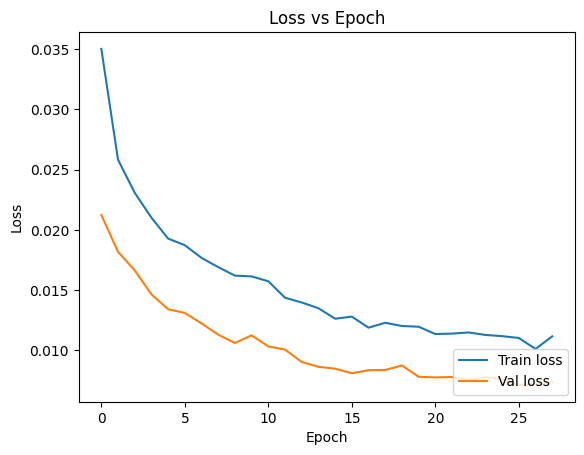

In [27]:
# Loss
plt.plot(range(num_epochs),Train_loss,label='Train loss')
plt.plot(range(num_epochs),Val_loss,label='Val loss')

plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

predict.shape = (400, 1, 192, 192)


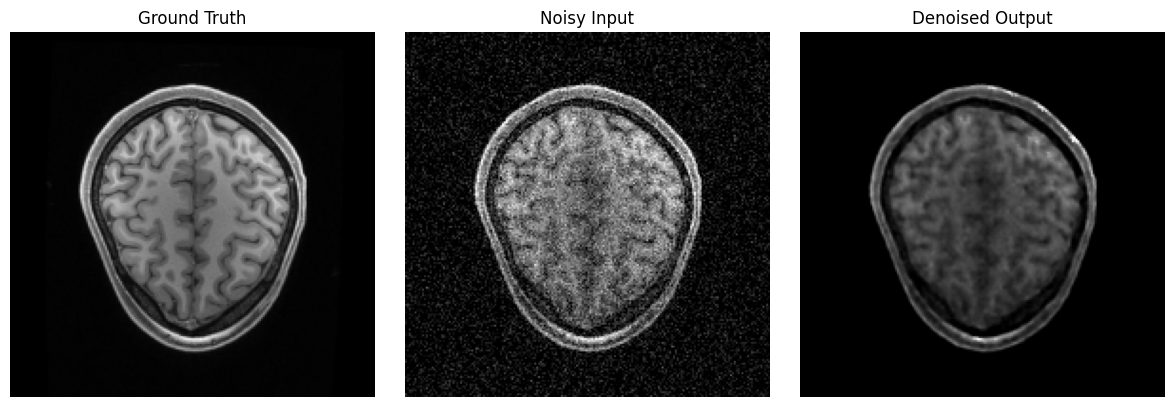

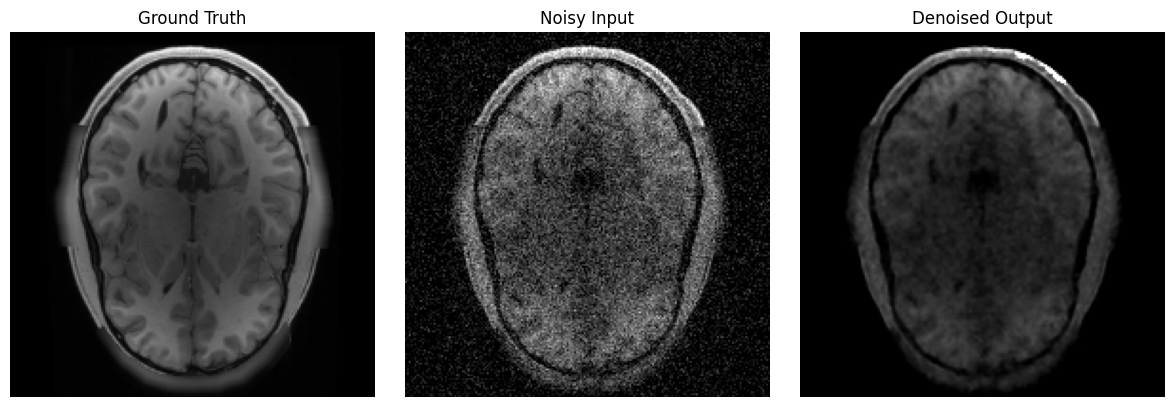

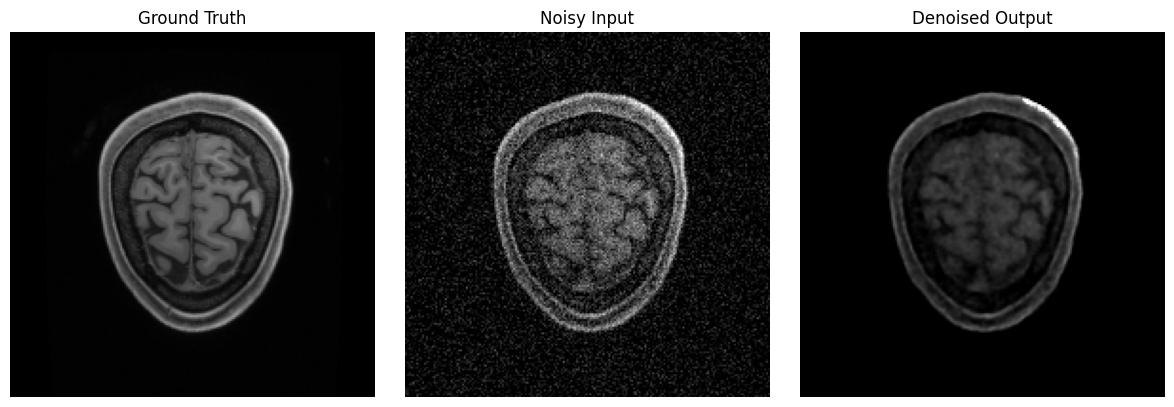

Average PSNR (noisy vs GT):    21.46 dB
Average PSNR (denoised vs GT): 21.39 dB


In [29]:
# Results

# predict = model(X_test)
# predict = predict.detach().numpy()
# y_test_show = y_test.detach().numpy()
# X_test_show = X_test.detach().numpy()
# print(predict.shape)

# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# predict = model(X_test_tensor)
# predict = predict.detach().numpy()
# y_test_show = y_test.detach().numpy()
# X_test_show = X_test.detach().numpy()
# print(predict.shape)
# for i in range(3):
#     fig, axs = plt.subplots(1, 3, figsize=(12, 4))

#     axs[0].imshow(y_test_show[i, 0], cmap='gray')
#     axs[0].set_title("Ground Truth")
#     axs[0].axis('off')

#     axs[1].imshow(X_test_show[i, 0], cmap='gray')
#     axs[1].set_title("Noisy Input")
#     axs[1].axis('off')

#     axs[2].imshow(predict[i, 0], cmap='gray')
#     axs[2].set_title("Denoised Output")
#     axs[2].axis('off')

#     plt.tight_layout()
#     plt.show()


# # Put your codes here to show results for three test images;
# # For each test case, show the ground truch (without noise added), the noisy image before denoising and the denoised image (network output)
# # ---
# # Notes: you don't have to follow this structure as long as you can build the network correctly

# print('PSNR: %s' % peak_signal_noise_ratio(X_test_show,predict)) # Note: Show the average PSNR before and after denoising
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
predict = model(X_test_tensor).detach().cpu().numpy()   # shape (N, C, H, W)

# 2) Make sure y_test_show / X_test_show are NumPy arrays
if torch.is_tensor(y_test):
    y_test_show = y_test.detach().cpu().numpy()
else:
    y_test_show = np.array(y_test)

if torch.is_tensor(X_test):
    X_test_show = X_test.detach().cpu().numpy()
else:
    X_test_show = np.array(X_test)

print("predict.shape =", predict.shape)

# 3) Plot the first 3 examples
for i in range(3):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(y_test_show[i, 0], cmap='gray')
    axs[0].set_title("Ground Truth")
    axs[0].axis('off')

    axs[1].imshow(X_test_show[i, 0], cmap='gray')
    axs[1].set_title("Noisy Input")
    axs[1].axis('off')

    axs[2].imshow(predict[i, 0], cmap='gray')
    axs[2].set_title("Denoised Output")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

# 4) Compute PSNRs
#   – noisy vs ground truth
psnr_noisy    = np.mean([
    peak_signal_noise_ratio(y_test_show[j,0], X_test_show[j,0], data_range=1.0)
    for j in range(len(y_test_show))
])
#   – denoised vs ground truth
psnr_denoised = np.mean([
    peak_signal_noise_ratio(y_test_show[j,0], predict[j,0], data_range=1.0)
    for j in range(len(y_test_show))
])

print(f"Average PSNR (noisy vs GT):    {psnr_noisy:.2f} dB")
print(f"Average PSNR (denoised vs GT): {psnr_denoised:.2f} dB")


In [ ]:
# Task 5 (20 pts): Try to optimize network structure (e.g., number of layers) and hyperparameters (e.g., kernel size, feature size per layer, training parameters) to achieve a PSNR of 30 (db)

In [7]:
import torch
import torch.nn as nn

class DeepDenoisingCNN(nn.Module):
    """
    Convolutional autoencoder for image denoising.

    Args:
        in_channels:  Number of input channels (e.g. 1 for grayscale).
        base_filters: Number of filters in the first conv block.
    """
    def __init__(self, in_channels: int = 1, base_filters: int = 64):
        super().__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(in_channels, base_filters, kernel_size=3, padding=1)
        self.enc_bn1   = nn.BatchNorm2d(base_filters)
        self.enc_conv2 = nn.Conv2d(base_filters, base_filters, kernel_size=3, padding=1)
        self.enc_bn2   = nn.BatchNorm2d(base_filters)
        self.pool      = nn.MaxPool2d(2)
        self.enc_conv3 = nn.Conv2d(base_filters, base_filters * 2, kernel_size=3, padding=1)
        self.enc_bn3   = nn.BatchNorm2d(base_filters * 2)

        # Decoder
        self.upconv1   = nn.ConvTranspose2d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.dec_bn1   = nn.BatchNorm2d(base_filters)
        self.upconv2   = nn.ConvTranspose2d(base_filters, base_filters, kernel_size=2, stride=2)
        self.dec_bn2   = nn.BatchNorm2d(base_filters)
        self.out_conv  = nn.Conv2d(base_filters, in_channels, kernel_size=3, padding=1)

        # Activations
        self.relu      = nn.ReLU(inplace=True)
        self.sigmoid   = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Encoder
        x = self.relu(self.enc_bn1(self.enc_conv1(x)))
        x = self.relu(self.enc_bn2(self.enc_conv2(x)))
        x = self.pool(x)
        x = self.relu(self.enc_bn3(self.enc_conv3(x)))
        x = self.pool(x)

        # Decoder
        x = self.relu(self.dec_bn1(self.upconv1(x)))
        x = self.relu(self.dec_bn2(self.upconv2(x)))
        x = self.sigmoid(self.out_conv(x))
        return x

    model = DeepDenoisingCNN(in_channels=1, base_filters=64)
    print(model)


DeepDenoisingCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 64, kernel_size

In [8]:
# Task 4 (15 pts): Traing the network for denoising
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 10  # You can adjust this based on when the model converges
Train_loss = []
Val_loss = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    batch_count = 0

    model.eval()
    train_loss = 0
    for batch_no, (noisy_batch, clean_batch) in enumerate(train_loader):
        # Forward pass
        optimizer.zero_grad()
        # print(noisy_batch.shape)
        outputs = model(noisy_batch)
        loss = criterion(outputs, clean_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        batch_count += 1

    # Calculate average training loss
    avg_train_loss = train_loss / batch_count
    Train_loss.append(avg_train_loss)

    val_loss = 0
    val_batch_count = 0
    with torch.no_grad():  # No gradient computation needed for validation
        for batch_no, (noisy_batch, clean_batch) in enumerate(test_loader):
            # Forward pass
            outputs = model(noisy_batch)
            loss = criterion(outputs, clean_batch)
            val_loss += loss.item()
            val_batch_count += 1

    # Calculate average validation loss
    avg_val_loss = val_loss / val_batch_count
    Val_loss.append(avg_val_loss)

    # Print average loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    # print(f'Training Loss: {avg_train_loss:.4f}')
    # print(f'Validation Loss: {avg_val_loss:.4f}')

Epoch [1/10], Training Loss: 0.0686, Validation Loss: 0.0529
Epoch [2/10], Training Loss: 0.0144, Validation Loss: 0.0059
Epoch [3/10], Training Loss: 0.0040, Validation Loss: 0.0028
Epoch [4/10], Training Loss: 0.0024, Validation Loss: 0.0022
Epoch [5/10], Training Loss: 0.0020, Validation Loss: 0.0019
Epoch [6/10], Training Loss: 0.0017, Validation Loss: 0.0017
Epoch [7/10], Training Loss: 0.0016, Validation Loss: 0.0015
Epoch [8/10], Training Loss: 0.0015, Validation Loss: 0.0015
Epoch [9/10], Training Loss: 0.0014, Validation Loss: 0.0016
Epoch [10/10], Training Loss: 0.0014, Validation Loss: 0.0013


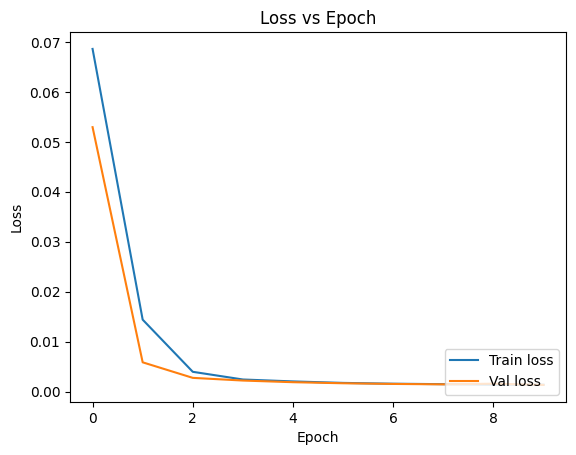

In [9]:
# Loss
plt.plot(range(num_epochs),Train_loss,label='Train loss')
plt.plot(range(num_epochs),Val_loss,label='Val loss')

plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

predict.shape = (400, 1, 192, 192)


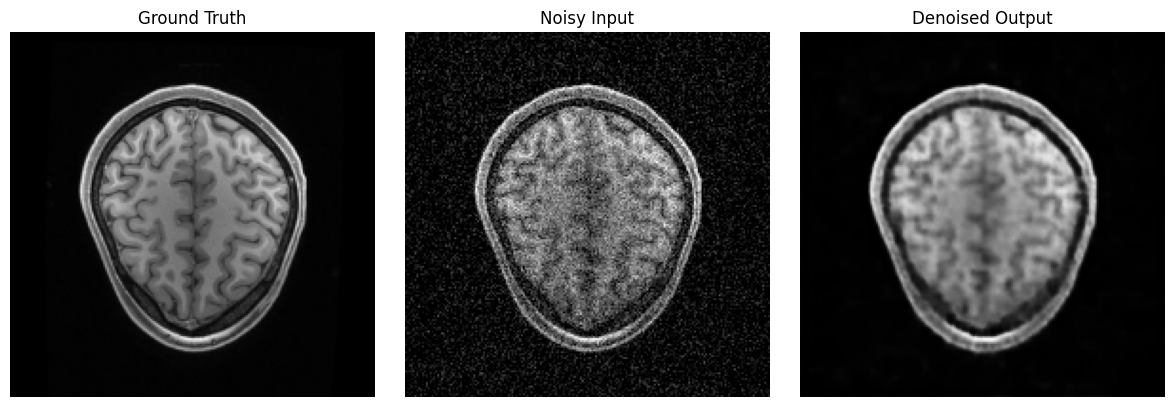

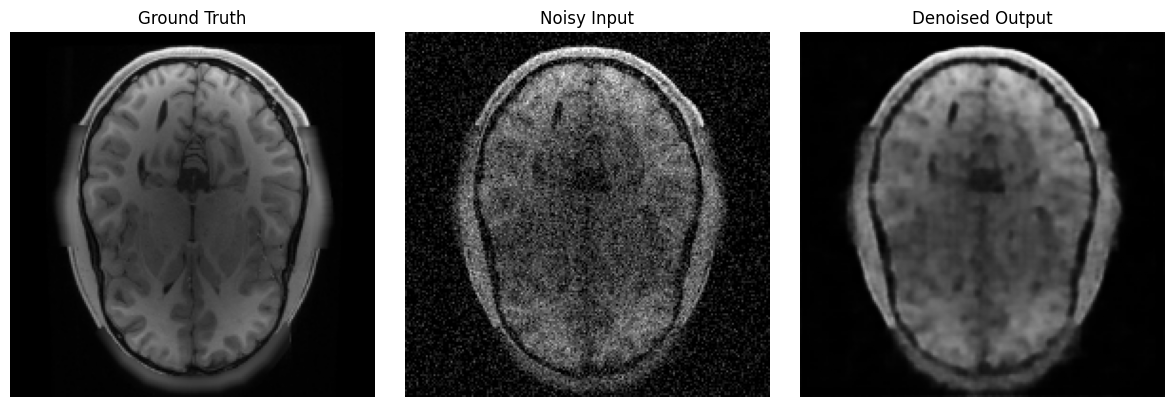

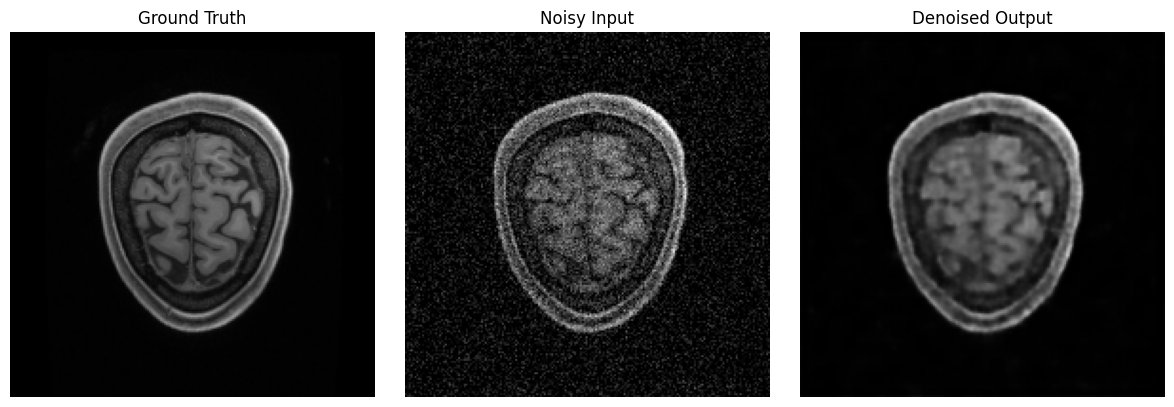

Average PSNR (noisy vs GT):    21.46 dB
Average PSNR (denoised vs GT): 28.77 dB


In [10]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
predict = model(X_test_tensor).detach().cpu().numpy()   # shape (N, C, H, W)

# 2) Make sure y_test_show / X_test_show are NumPy arrays
if torch.is_tensor(y_test):
    y_test_show = y_test.detach().cpu().numpy()
else:
    y_test_show = np.array(y_test)

if torch.is_tensor(X_test):
    X_test_show = X_test.detach().cpu().numpy()
else:
    X_test_show = np.array(X_test)

print("predict.shape =", predict.shape)

# 3) Plot the first 3 examples
for i in range(3):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(y_test_show[i, 0], cmap='gray')
    axs[0].set_title("Ground Truth")
    axs[0].axis('off')

    axs[1].imshow(X_test_show[i, 0], cmap='gray')
    axs[1].set_title("Noisy Input")
    axs[1].axis('off')

    axs[2].imshow(predict[i, 0], cmap='gray')
    axs[2].set_title("Denoised Output")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

# 4) Compute PSNRs
#   – noisy vs ground truth
psnr_noisy    = np.mean([
    peak_signal_noise_ratio(y_test_show[j,0], X_test_show[j,0], data_range=1.0)
    for j in range(len(y_test_show))
])
#   – denoised vs ground truth
psnr_denoised = np.mean([
    peak_signal_noise_ratio(y_test_show[j,0], predict[j,0], data_range=1.0)
    for j in range(len(y_test_show))
])

print(f"Average PSNR (noisy vs GT):    {psnr_noisy:.2f} dB")
print(f"Average PSNR (denoised vs GT): {psnr_denoised:.2f} dB")

In [ ]:
# ---
# Put your codes here to
# Similar to showing the results in Task 4, after optimization, show the denoising results for 3 test images as above and show the PSNR w.r.t. the ground truth
# ---

Task 6 (20 pts; Graduate students only): Conmpare two cases, 1) Training data and testing data (at inference stage) have the same SNR; and 2) Training data and inference data have different SNRs (e.g., train the network at a higher SNR/lower SNR, and use it to denoise images with a lower/higher SNR). Compare the PSNR performance and image quality and provide your interpretation and understanding of the results